# Mechanistic model with data considering the sampling rate.

### Friday, April 18, 2025. Viernes Santo.
### Ana Daniela del Río Pulido

Previous notebook: Mechanistic model with data

# Modify the code considering a sampling rate of 1.5 s.

In [33]:
import math
import os
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats 

# commands to create high-resolution figures with large labels, credits Erin McKiernan
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting


In [4]:
def channel(x, mu=1, sigma=1):
    ''' Defines a single channel function based on a normal distribution. c
    '''
    return (np.exp(-(x-mu)**2/(2*sigma**2)))/(sigma*np.sqrt(2*np.pi))

def scalar_value(stimulus, weights, mus, sigmas):
    ''' Applies the channel function to a single stimulus, c=c(s)
    '''
    channel_values = np.asarray([channel(stimulus, mus[i], sigmas[i]) for i in range(n_channels)])
    y = np.sum(weights * channel_values)
    return y

def yy_vector(stimulus_vec, weights, mus, sigmas): # Creates the vector of scalar values of y
    ''' Calculates the vector of scalar values, that is, applies the channel function to a stimulus vector. c(ss)
    '''
    n = len(stimulus_vec)
    yy = np.zeros(n)
    for i in range(n):
        if stimulus_vec[i] == 0: # If the stimulus is 0, then don't calculate anything and output 0.
            yy[i] = 0
        else: # Calculates the y output for that timepoint.
            yy[i] = scalar_value(stimulus_vec[i], weights, mus, sigmas)
    # yy = np.asarray([scalar_value(stimulus_vec[i], weights, mus, sigmas) for i in range(n)])
    return yy

def HRF(t, A = 5, alpha_1 = 6, alpha_2 = 16, beta_1 = 1, beta_2 = 1, c = 1/6):
    ''' Hemodynamic response function (HRF) as defined in Friston 1998.
    '''
    numerator_1 = t**(alpha_1 - 1)*beta_1**(alpha_1) * np.exp(-beta_1*t)
    numerator_2 = t**(alpha_2 - 1)*beta_2**(alpha_2) * np.exp(-beta_2*t)
    return A * (numerator_1/math.gamma(alpha_1) - c*numerator_2/math.gamma(alpha_2))

# The HRF considers a time t that is in s.

In [6]:
n_channels = 9
n_timepoints = 2528
# stim_freq = 100
TR = 1.5 # in seconds. This is the sampling interval. See notes on Friday, April 18, 2025, specifically Goal 2.

# What's the difference between np.asarray and np.array?
# See here: https://stackoverflow.com/questions/14415741/what-is-the-difference-between-np-array-and-np-asarray
timeaxis_s = np.asarray([i*TR for i in range(n_timepoints)]) # time
timeaxis_min = timeaxis_s/60
t_hrf = timeaxis_s[:30]  # IS THIS RIGHT???

# Stimulus
stimulus_vec = np.zeros(n_timepoints)
stimulus_vec[5] = 1 # rd.randint(100,340)
stimulus_vec[20] = 1
stimulus_vec[25] = 1
stimulus_vec[53] = 1

# Parameters that define the channels
weights = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])

yy = yy_vector(stimulus_vec, weights, mus, sigmas)
hrf = HRF(t_hrf)
BOLD_predicted = np.convolve(yy, hrf)

-3.0892059588038797e-07


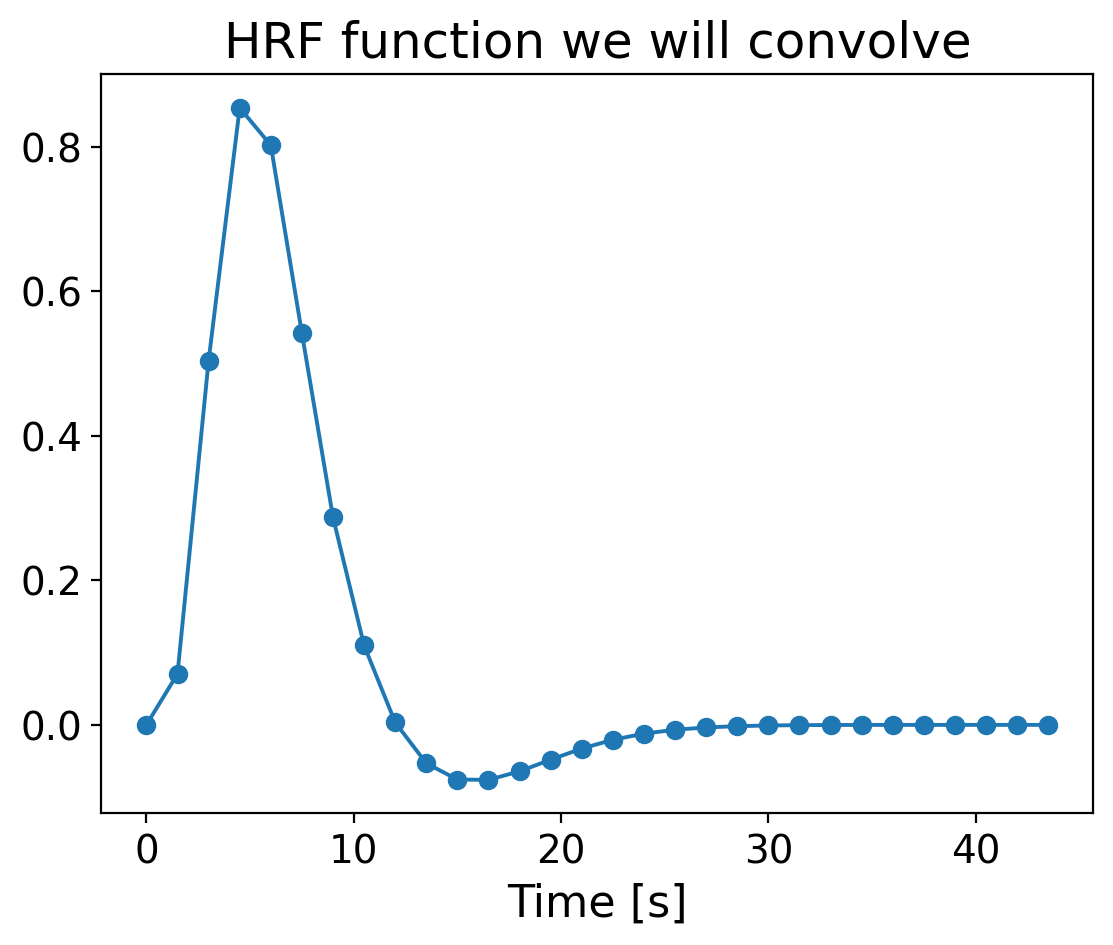

In [7]:
print(hrf[len(hrf)-1]) # THis value should be very close to zero.
plt.plot(t_hrf, hrf, marker="o")
plt.title("HRF function we will convolve")
plt.xlabel("Time [s]")
plt.show()

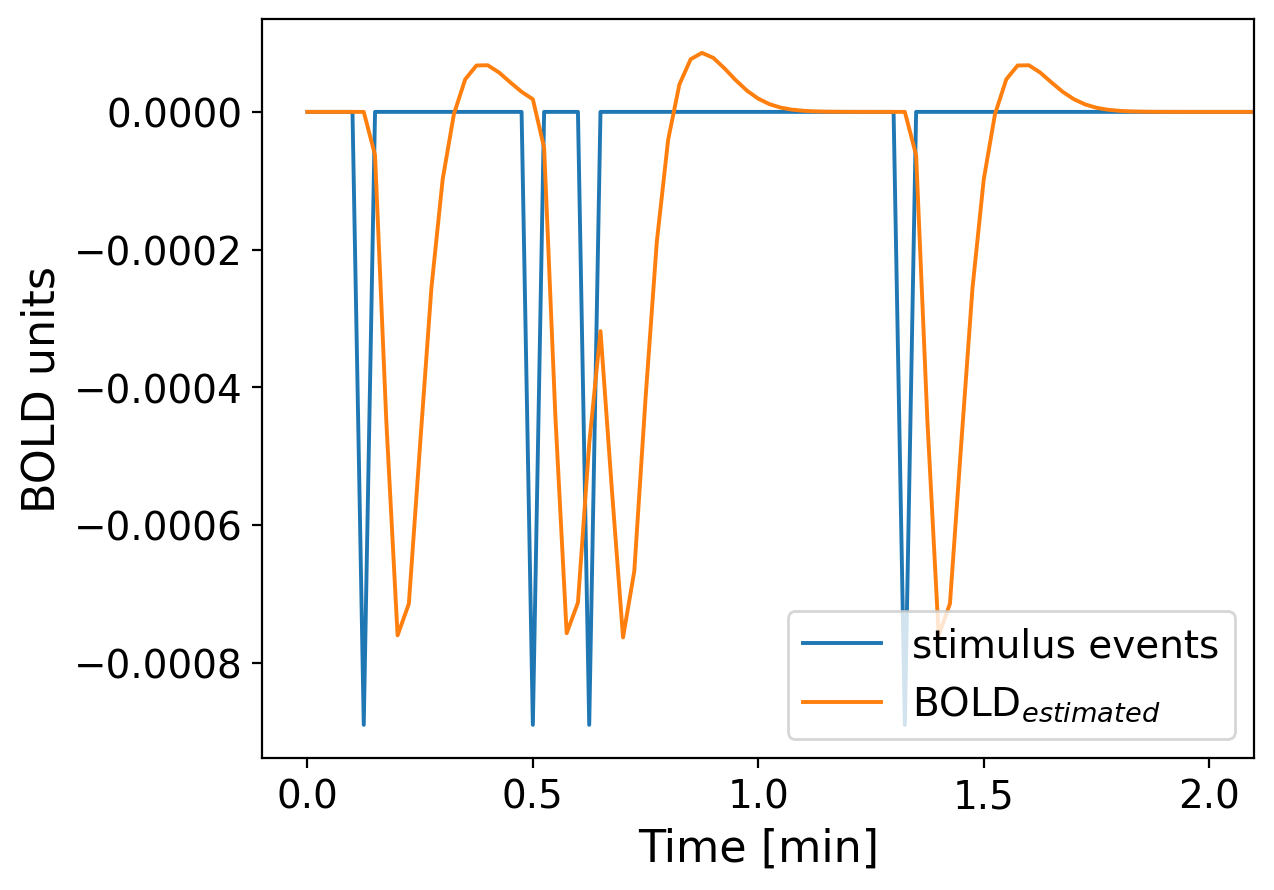

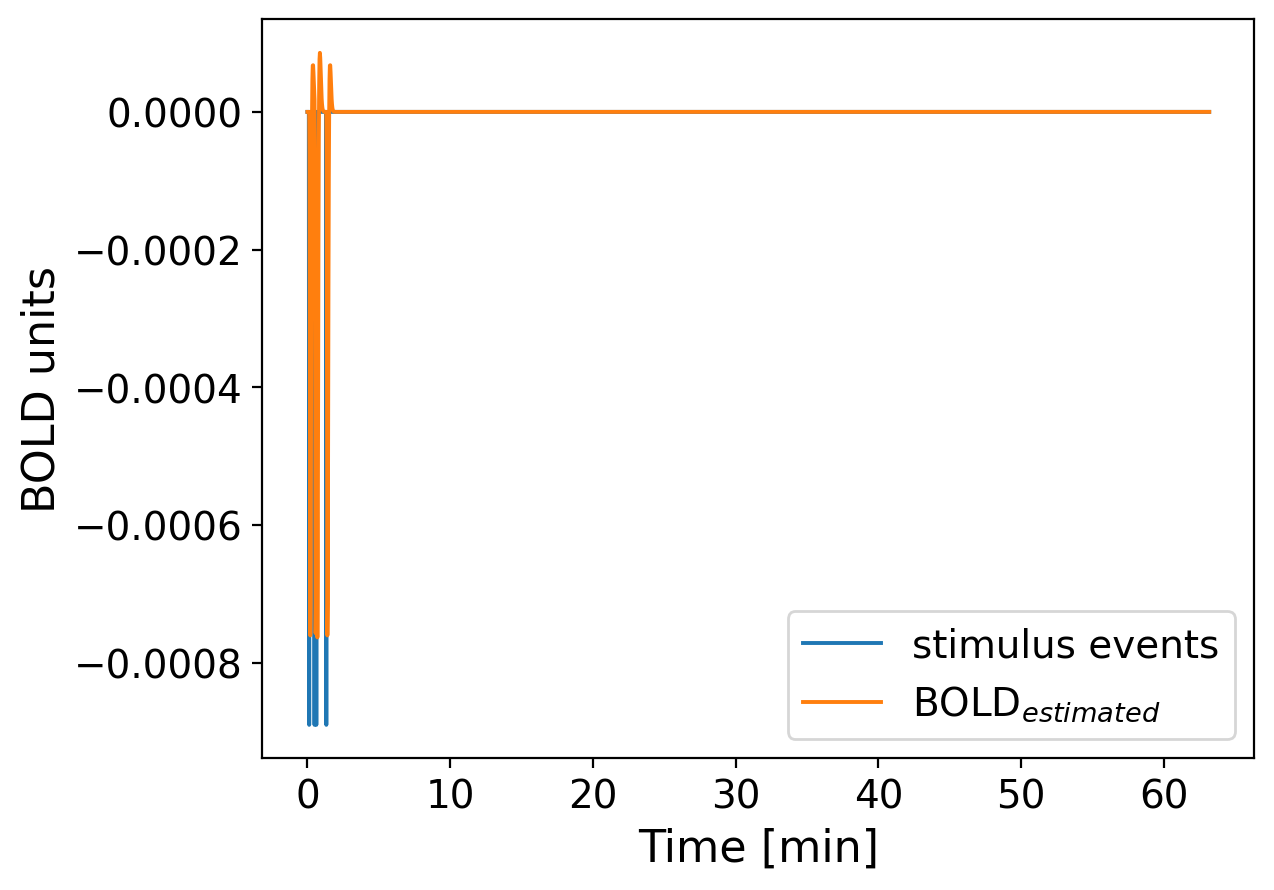

In [8]:
plt.plot(timeaxis_min, yy, label="stimulus events")
plt.plot(timeaxis_min, BOLD_predicted[:len(yy)], label=u"BOLD$_{estimated}$")
plt.xlim([-0.1, 2.1])
plt.xlabel("Time [min]")
plt.ylabel("BOLD units")
plt.legend()
plt.show()

plt.plot(timeaxis_min, yy, label="stimulus events")
plt.plot(timeaxis_min, BOLD_predicted[:len(yy)], label=u"BOLD$_{estimated}$")
# plt.xlim([-1, 3])
plt.xlabel("Time [min]")
plt.ylabel("BOLD units")
plt.legend()
plt.show()

Awesome. This is what we would expect for the predicted BOLD for a stimulus of only 4 events in the first 2 min of the recording.

# Now, let's upload some real data.

In [10]:
# Code for uploading the stimulus timeseries.
def binarize_event_file(filepath, TR=1.0, max_time=600):
    """
    Code created by ChatGPT
    Convert AFNI stim timing file into a binarized array.

    Parameters:
        filepath (str): Path to the .txt file
        TR (float): Time resolution in seconds (default is 2s)
        max_time (int): Max time to consider (default is 600s)

    Returns:
        np.ndarray: Binary array of shape (n_timepoints,)
    """
    n_timepoints = int(max_time / TR)
    binary_vector = np.zeros(n_timepoints, dtype=int)

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            if '*' in line:
                continue
            for val in line.strip().split():
                try:
                    time = float(val)
                    idx = int(time // TR)
                    if 0 <= idx < n_timepoints:
                        binary_vector[idx] = 1
                except ValueError:
                    continue  # Skip malformed values

    return binary_vector


In [11]:
# path = "Session1/EventFiles/"
# Documents/Multisensory_lab/FreqAP/Session1/EventFiles/FreqAP08_01_L100_1.txt

filepath = "Session1/EventFiles/FreqAP08_01_L100_1.txt" # Left 1 is left near unattend.
real_stim_01_L100_1 = binarize_event_file(filepath)
print(real_stim_01_L100_1)
print(len(real_stim_01_L100_1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### Cool! Now, given that stimulus vector, create a predicted BOLD response given some random weights.

Eventually, I will have to modify the previous function to consider more than 1 stimulus file. Note I am only considering session1's stimulus files.

# HERE

# See here: https://chatgpt.com/c/67fead6e-7740-8002-b99f-e7dedc65bec6 


In [26]:
# Parameters that define the channels
n_channels = 9
weights = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])

# Creates the HRF function
t = np.asarray([i for i in range(25)])
hrf = HRF(t)

# Stimulus
stim_freq = 100
n_timepoints = len(real_stim_01_L100_1) # 300
# stimulus_vec = np.zeros(n_timepoints)
time = np.asarray([i for i in range(n_timepoints)])

yy = yy_vector(real_stim_01_L100_1, weights, mus, sigmas)

BOLD_predicted = np.convolve(yy, hrf)

###
# print(length_timeseries) # 2528
# TR = 1.5 # in seconds. This is the sampling interval. See notes on Friday, April 18, 2025, specifically Goal 2.

# timeaxis_s = np.array([i*TR for i in range(length_timeseries)])
# timeaxis_min = timeaxis_s/60
# # Woah. 2528*1.5/60 = 63.2 min of data.
print(n_timepoints)

600


# Oh my goodness. Alignment!
### There is a dephase between the timeseries and the regressors. How do I know what times in the EventFiles folder (600 timepoints) correspond to the 63 min the timeseries last? In other words, how do the event times align with the errts dataset?
Just asked ChatGPT.

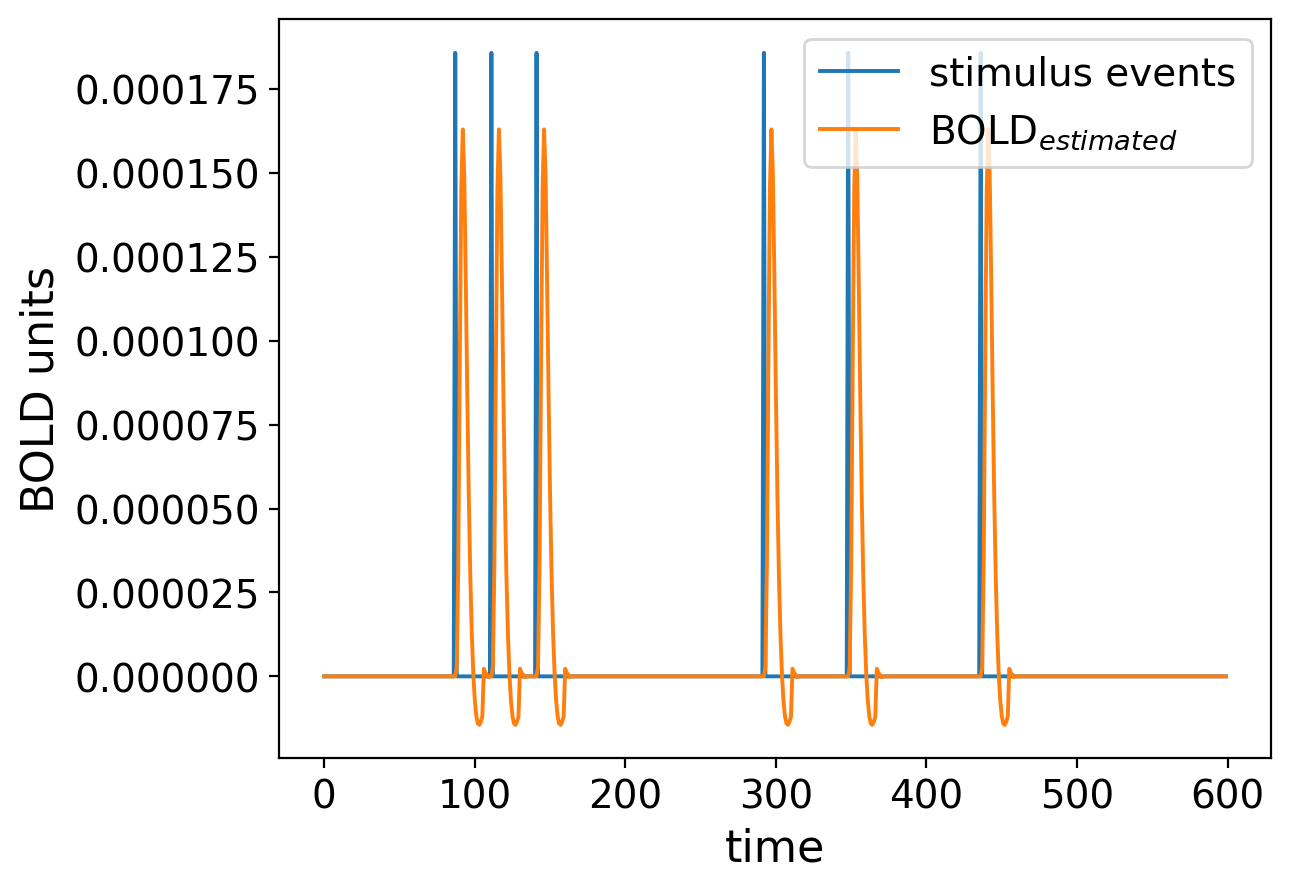

In [14]:
plt.plot(time, yy, label="stimulus events")
plt.plot(time, BOLD_predicted[:len(yy)], label=u"BOLD$_{estimated}$")
plt.xlabel("time")
plt.ylabel("BOLD units")
plt.legend()
plt.show()

Wait a second. This does not make sense. Why are there 6 stimulus events, but the BOLD_estimated have more than 6 bumps? LOL. Debugging. I was inputting something that didn't make sense to the HRF function. It now looks like what I'd expect it to look like.

There are 2 options you could do now. 
1. Upload other stimulus files and create the BOLD_estimated for all the stimulus.
2. Obtain the error of the true timeseries with respect to the BOLD_estimated.

Let's do the first.

In [17]:
folder = "Session1/EventFiles"

filenames = [
    "FreqAP08_01_L100_1.txt",
    "FreqAP08_01_L100_2.txt",
    "FreqAP08_01_L100_3.txt",
    "FreqAP08_01_L100_4.txt",
    "FreqAP08_02_L130_1.txt",
    "FreqAP08_02_L130_2.txt",
    "FreqAP08_02_L130_3.txt",
    "FreqAP08_02_L130_4.txt",
    "FreqAP08_03_L160_1.txt"
]

# Build binary matrix
binary_matrix = []

for fname in filenames:
    path = os.path.join(folder, fname)
    vec = binarize_event_file(path)
    binary_matrix.append(vec)

# Convert to NumPy array
binary_matrix = np.array(binary_matrix)

# Optional: print shape and preview
print("Matrix shape:", binary_matrix.shape)
print(binary_matrix)

Matrix shape: (9, 600)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
# Folder with your files
folder = "Session1/EventFiles"

# Pairs of numbering and corresponding frequencies (1-to-1)
numbering = [f"{i:02d}" for i in range(1, 10)]  # '01' to '07'
frequencies = list(range(100, 341, 30))        # 100 to 280 in steps of 30
conditions = [1, 2, 3, 4]

# Loop and generate filenames
left_binary_matrix = []
filenames = []

for num, freq in zip(numbering, frequencies):
    for cond in conditions:
        fname = f"FreqAP08_{num}_L{freq}_{cond}.txt"
        fpath = os.path.join(folder, fname)
        try:
            vec = binarize_event_file(fpath)
            left_binary_matrix.append(vec)
            filenames.append(fname)
        except FileNotFoundError as e:
            print(f"Skipping: {e}")

# Convert to matrix
left_binary_matrix = np.array(left_binary_matrix)
print("Binary matrix shape:", left_binary_matrix.shape)

Binary matrix shape: (36, 600)


Awesome. Now this is for the left hand. We need to consider the right hand and the oddball. But for now, we will leave it as is.

So, this binary_matrix for the left hand only has 0 and 1 values. Now, we can generate a left stimulus matrix with the actual frequency stimulus.

In [20]:
# Code created by DeepSeek.
# Step 1: Repeat each frequency 4 times to match the 32 rows
repeated_frequencies = np.repeat(frequencies, 4)
print(repeated_frequencies)
print(len(repeated_frequencies)) # THIS SHOULD BE 36!!
# Step 2: Reshape to (36, 1) for broadcasting
frequency_multipliers = repeated_frequencies.reshape(-1, 1)

# Step 3: Multiply the binary matrix by the frequency multipliers
left_stim_matrix = left_binary_matrix * frequency_multipliers

print(np.max(left_stim_matrix))
print(np.min(left_stim_matrix))

[100 100 100 100 130 130 130 130 160 160 160 160 190 190 190 190 220 220
 220 220 250 250 250 250 280 280 280 280 310 310 310 310 340 340 340 340]
36
340
0


### Awesome! Now, create the BOLD_estimated for the `left_stim_matrix`.

Yo, you are jumping again. First try 2 simulated stimulus vectors and make sure that the code works properly before you insert real data.
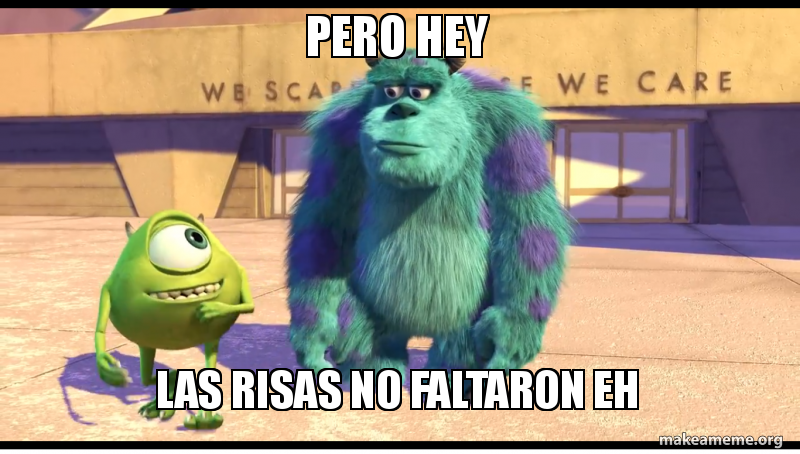

In [23]:
# Considering 2 simulated stimulus

# Parameters that define the channels
n_channels = 9
weights = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])

# Creates the HRF function
t = np.asarray([i for i in range(25)])
hrf = HRF(t)

# Stimulus
n_timepoints = 300
stim_freq = 100
time = np.asarray([i for i in range(n_timepoints)])

stimulus_vec1 = np.zeros(n_timepoints)
stimulus_vec1[5] = 1
stimulus_vec1[200] = 1
stimulus_vec1[25] = 1
stimulus_vec1[267] = 1 # stim_freq

stimulus_vec2 = np.zeros(n_timepoints)
stimulus_vec2[50] = 1
stimulus_vec2[240] = 1
stimulus_vec2[111] = 1
stimulus_vec2[205] = 1

# How would you consider more than 1 stimulus?
yyy = yy_vector(stimulus_vec1, weights, mus, sigmas)
yyy += yy_vector(stimulus_vec2, weights, mus, sigmas)

BOLD_predicted = np.convolve(yyy, hrf)

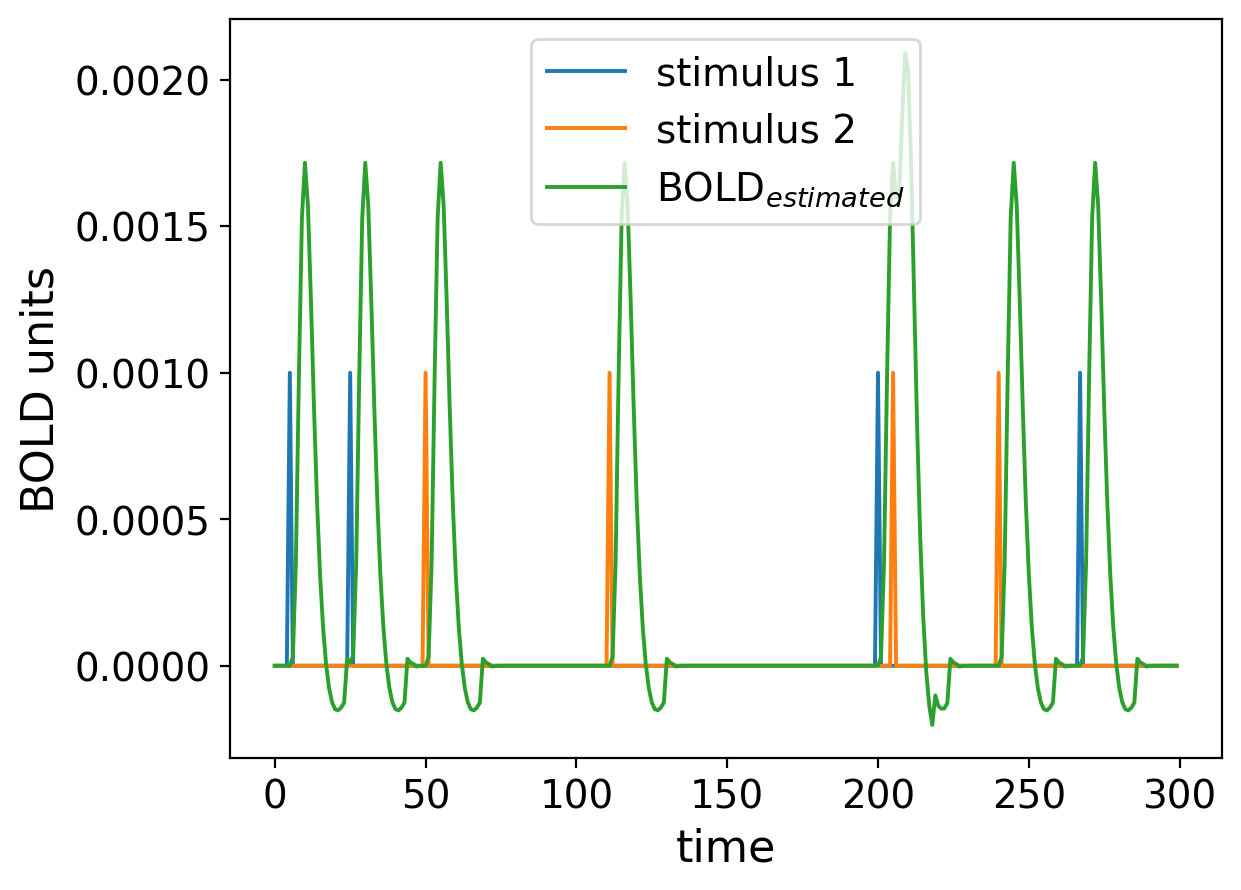

In [24]:
plt.plot(time, stimulus_vec1/1000, label="stimulus 1")
plt.plot(time, stimulus_vec2/1000, label="stimulus 2")
plt.plot(time, BOLD_predicted[:n_timepoints], label=u"BOLD$_{estimated}$")
plt.xlabel("time")
plt.ylabel("BOLD units")
plt.legend()
plt.show()

Now, let's consider multiple stimulus from the real data.

In [26]:
# Parameters that define the channels
n_channels = 9
weights = [rd.random()*2-1 for i in range(n_channels)] # Values in the [-1, 1] range.
mus = np.asarray([50*i+50 for i in range(n_channels)])
sigmas = np.asarray([50 for i in range(n_channels)])

# Creates the HRF function
t = np.asarray([i for i in range(25)])
hrf = HRF(t)

# Stimulus
# stim_freq = 100
n_timepoints = np.shape(left_binary_matrix)[1] # 300
# stimulus_vec = np.zeros(n_timepoints)
time = np.asarray([i for i in range(n_timepoints)])

# Check this yy_vector.
# How would you consider more than 1 stimulus?
yyy = np.zeros(np.shape(left_stim_matrix)[1])
for i in range(np.shape(left_stim_matrix)[0]):
    yy = yy_vector(left_stim_matrix[i], weights, mus, sigmas)
    yyy += yy
# You have to calculate the yy value for every stimulus. Then, at every timepoint, add them. Thys, you will obtain a single yyy value
# This yyy value is what you want to convolve with the BOLD_predicted.

BOLD_predicted = np.convolve(yyy, hrf)

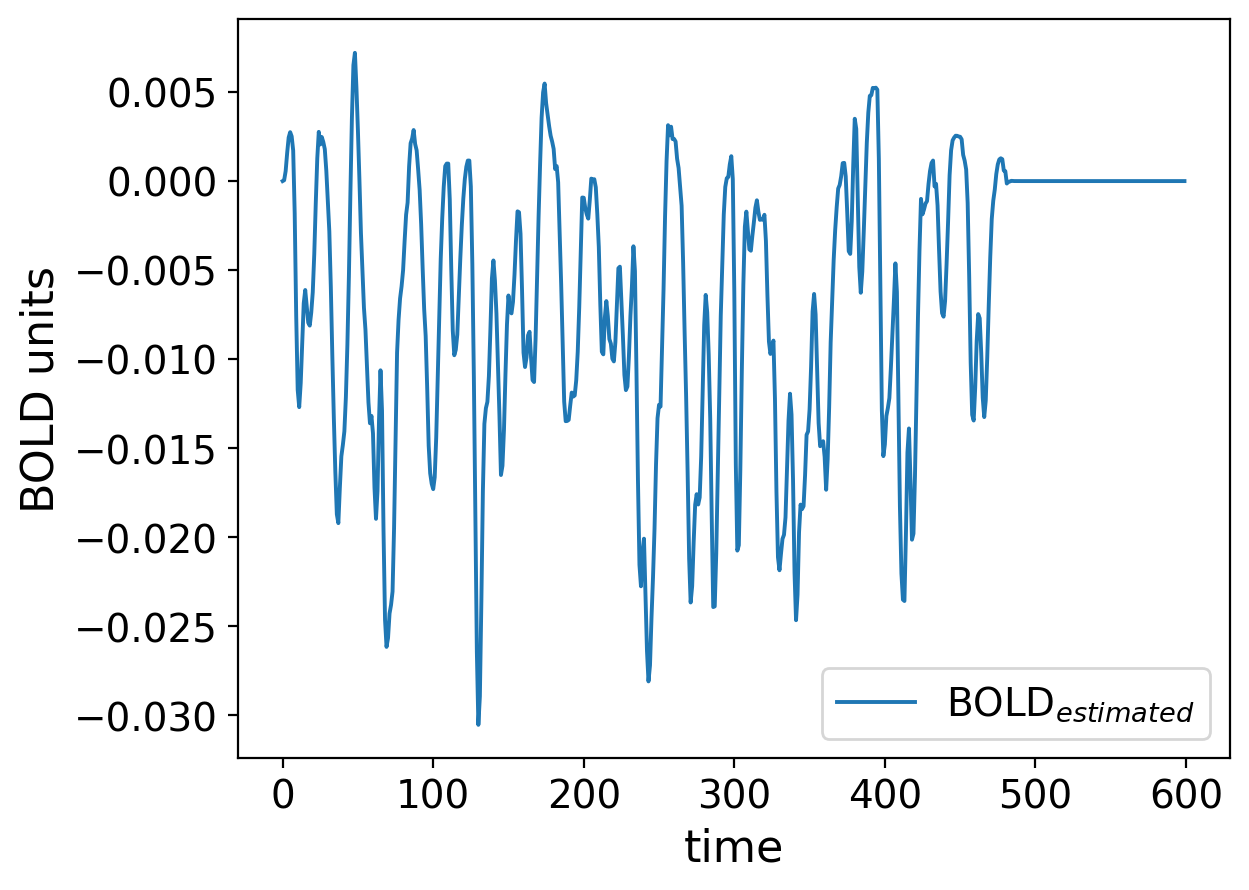

In [27]:
# for i in range(np.shape(left_stim_matrix)[0]):
#     plt.plot(time, left_stim_matrix[i], label="stimulus events")
plt.plot(time, BOLD_predicted[:len(yy)], label=u"BOLD$_{estimated}$")
plt.xlabel("time")
plt.ylabel("BOLD units")
plt.legend()
plt.show()

Dude, you forgot that the TR for the stimulus being sampled is 2 s. I think. Where would you check? Dude! yes, it was in the $TR=2$. I changed it to 1.

That makes sense now because the highest values I am finding inside the EventFiles files,

436.50

462

However, the values that are being saved are in the 300 range. Why? Perhaps it is considering a sampling rate of 2.

Cool, yo. Now, import the real timeseries and calculate the error signal with respect to the true timeseries.

### Importing the real timeseries.

In [29]:
# f = open('FreqAP08_mask_1session.txt', 'r')

# Prompt for ChatGPT: Create code whose input is the txt file with entries like the one below. Every row is a different voxel. There is a total of 2929 voxels. The first 3 columns are the coordinates of that voxel. The next entries are the values of that voxel as a time series. What data structure would you suggest for saving this information and why?
# Suggested the use of a dictionary and the following code:

def load_voxel_data(file_path):
    voxel_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            coords = tuple(map(float, parts[:3]))  # (x, y, z)
            time_series = np.array(list(map(float, parts[3:])))
            voxel_dict[coords] = time_series
    return voxel_dict

In [31]:
folder = "Session1/"
fname = "FreqAP08_masked_errts_from_nuisssance_regressors_session1.txt"
fpath = os.path.join(folder, fname)
voxel_data = load_voxel_data(fpath)
n_voxels = len(voxel_data)
print(n_voxels)  # Should be 2929

key1 = (-57.0, -5.5, 37.5)
voxel1 = voxel_data[key1] # Time series of a specific voxel

length_timeseries = len(voxel1)
print(length_timeseries) # 2528
TR = 1.5 # in seconds. This is the sampling interval. See notes on Friday, April 18, 2025, specifically Goal 2.

timeaxis_s = np.array([i*TR for i in range(length_timeseries)])
timeaxis_min = timeaxis_s/60
# Woah. 2528*1.5/60 = 63.2 min of data.

2929
2528


# Oh my goodness. The timescales are WAY different. What does it mean that voxel1 has 2528 time entries? How does this map to the approx 10 min of data? It cannot be seconds of data.

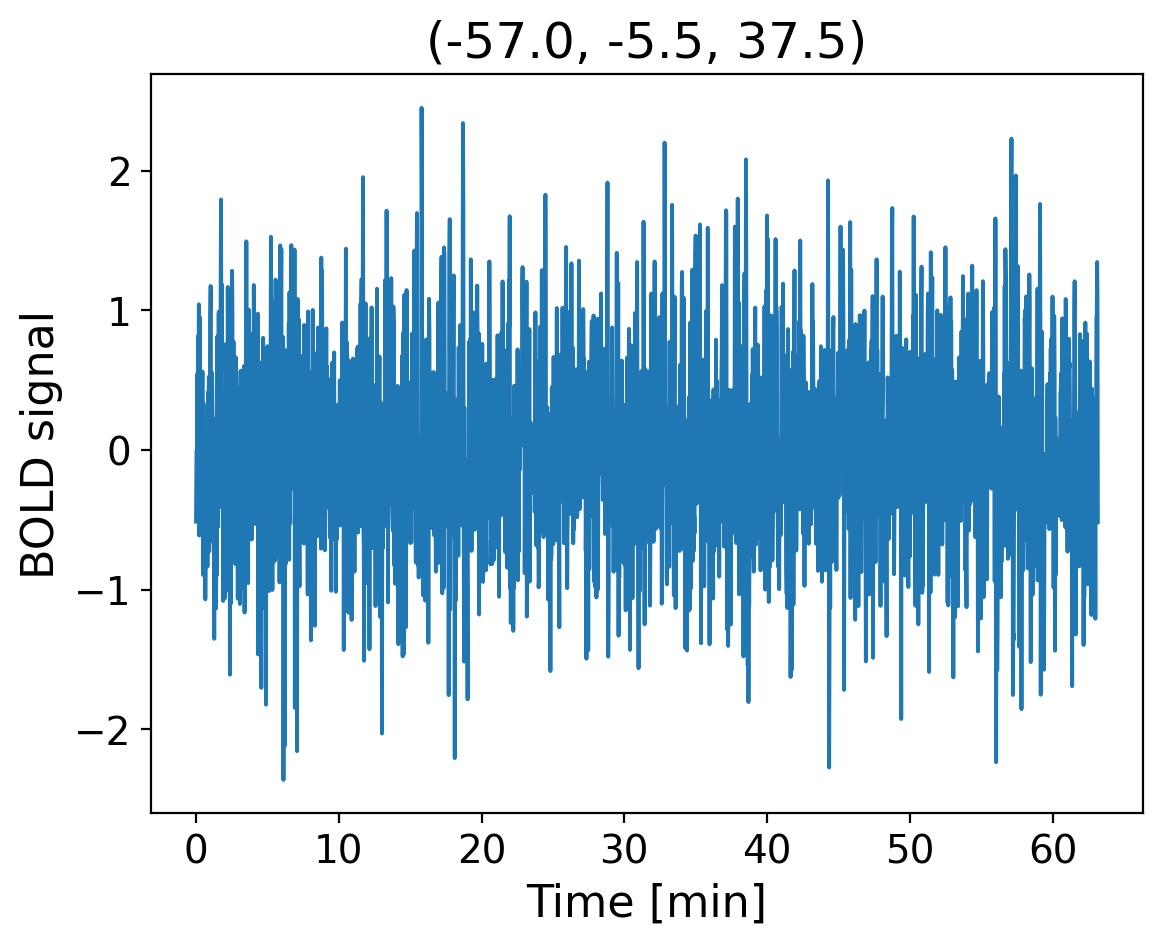

In [35]:
# Plotting the real time series of this voxel 1.

plt.plot(timeaxis_min, voxel1)
plt.xlabel("Time [min]")
plt.ylabel("BOLD signal")
plt.title(key1)
plt.show()

### Defining an error metric, the mean square error

See here: https://www.geeksforgeeks.org/python-mean-squared-error/

In [36]:
# DEfine a function that receives 2 datasets and obtains the mean squared error.
mean_squared_error(voxel1, BOLD_predicted)

NameError: name 'voxel1' is not defined

# Subgoal: Clean and upload the notebook to Github.

In [49]:
with open('Session1/L100_1.txt', 'r') as file:
    vector = file.readlines()


In [51]:
len(vector)

2528

In [53]:
np.argmax(vector)

1045

A HUEVO!!!! El primer valor distinto a 1 esta en el indice 1045 <3

### Labels for stim matrix:
1d_tool.py -infile X.stim.xmat.1D -show_labels
++ labels are: ['L100_1#0', 'L130_1#0', 'L160_1#0', 'L190_1#0', 'L220_1#0', 'L250_1#0', 'L280_1#0', 'L310_1#0', 'L340_1#0', 'R100_1#0', 'R130_1#0', 'R160_1#0', 'R190_1#0', 'R220_1#0', 'R250_1#0', 'R280_1#0', 'R310_1#0', 'R340_1#0', 'oddball_1#0', 'L100_2#0', 'L130_2#0', 'L160_2#0', 'L190_2#0', 'L220_2#0', 'L250_2#0', 'L280_2#0', 'L310_2#0', 'L340_2#0', 'R100_2#0', 'R130_2#0', 'R160_2#0', 'R190_2#0', 'R220_2#0', 'R250_2#0', 'R280_2#0', 'R310_2#0', 'R340_2#0', 'oddball_2#0', 'L100_3#0', 'L130_3#0', 'L160_3#0', 'L190_3#0', 'L220_3#0', 'L250_3#0', 'L280_3#0', 'L310_3#0', 'L340_3#0', 'R100_3#0', 'R130_3#0', 'R160_3#0', 'R190_3#0', 'R220_3#0', 'R250_3#0', 'R280_3#0', 'R310_3#0', 'R340_3#0', 'oddball_3#0', 'L100_4#0', 'L130_4#0', 'L160_4#0', 'L190_4#0', 'L220_4#0', 'L250_4#0', 'L280_4#0', 'L310_4#0', 'L340_4#0', 'R100_4#0', 'R130_4#0', 'R160_4#0', 'R190_4#0', 'R220_4#0', 'R250_4#0', 'R280_4#0', 'R310_4#0', 'R340_4#0', 'oddball_4#0']

In [ ]:
# Filename under FreqAP/Session1/
# X_stim_matrix_session1_full_GLM.txt